In [1]:
import sys
sys.path.insert(0, "../")
import numpy as np
import matplotlib.pyplot as plt
import rebound
from scipy import signal
from src.utilities.constants import rad2Deg, m2au, sec2year

In [2]:
sim = rebound.Simulation('../data/sim_inits/2020_12_17_sim.bin')
sim.remove(hash="Mercury")
sim.move_to_hel()
sim.N_active = sim.N
sim.integrator = 'WHFast'
ps = sim.particles
sim.dt = 864000 # 10 days of seconds

In [13]:
day = 24*3600
year = 365.25*day
t_max = int(10e6*year) #10 million years in seconds
dt = int(2e3*day)
out_times = np.arange(0, t_max, dt) # output every 2000 days

In [4]:
n = len(out_times)
print(n)

1826250


In [5]:
print(out_times[-1]/year)

9999994.524298426


In [6]:
orbit_data = {'Jupiter':[], 'Saturn': []}
for t in out_times:
    sim.integrate(t)
    for name in orbit_data:
        orbit_data[name].append(ps[name].calculate_orbit(ps["Sun"]))

In [145]:
def get_pr(o):
    return np.sin(0.5*o.inc)*np.sin(o.Omega)
def get_qr(o):
    return np.sin(0.5*o.inc)*np.cos(o.Omega)
def get_hr(o):
    return o.e*np.sin(o.pomega)
def get_kr(o):
    return o.e*np.cos(o.pomega)

In [140]:
twopi = 2*np.pi
fs = 1/dt*year # sampling frequency
pass_band_boundary = 10000 # Perodic perturbations < 1e4 year should be filtered out
dark_band_boundary = 281.49  # allow some gap for filter
w_pass = 1/pass_band_boundary*fs
w_max = 1/dark_band_boundary*fs
width = (w_max-w_pass)/fs

In [141]:
fs, w_pass, w_max, width

(0.182625,
 1.8262500000000003e-05,
 0.0006487797079825216,
 0.0034525240683505633)

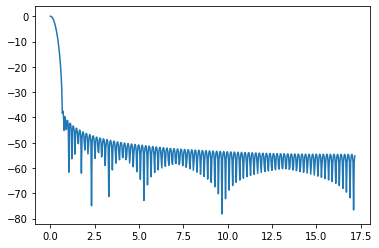

In [143]:
b = signal.firwin(171, w_pass, width=width*2 , fs=fs); a=1
w, H = signal.freqz(b, a) # calculate frequency response
plt.plot(w/fs, 10*np.log10(abs(H)))
# plt.xlim(0, 5e-3)
# plt.ylim(-6, 0)

/Users/bethclark/Projects/Flora_Family/venv/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/bethclark/Projects/Flora_Family/venv/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(1e-05, 1.0)

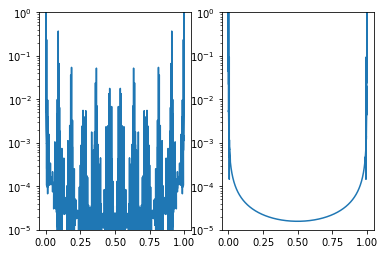

In [147]:
x_n = [get_hr(o) for o in orbit_data['Jupiter']]
n = len(x_n)
fhat = np.fft.fft(x_n)
PSD = fhat * np.conj(fhat) / n
freq = (1/(n)) * np.arange(n)

plt.subplot(1,2,1)
plt.semilogy(freq, np.sqrt(PSD))
plt.ylim(1e-5, 1e0)
# plt.xlim(0, .06)

f_lp = signal.filtfilt(b, 1, x_n)
fhat_lp = np.fft.fft(f_lp)
PSD_lp = fhat_lp * np.conj(fhat_lp) / n

plt.subplot(1,2,2)
plt.semilogy(freq, np.sqrt(PSD_lp))
plt.ylim(1e-5, 1e0)
# plt.xlim(0, .06)

/Users/bethclark/Projects/Flora_Family/venv/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(0.0, 0.6)

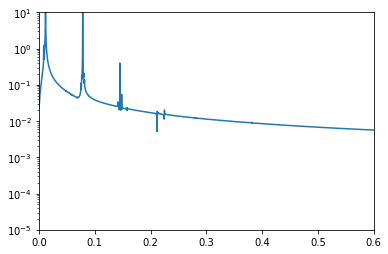

In [156]:
plt.semilogy((3600/(5.4757*n)) * np.arange(n), np.sqrt(PSD_lp))
plt.ylim(1e-5, 1e1)
plt.xlim(0, .6)

In [148]:
n

1826250